### ROC 곡선
정밀도-재현율 곡선처럼 모든 임계값을 고려하지만 진짜 양성비율(TPR)에 대한 거짓 양성 비율(FPR)을 나타냄  
ROC 곡선은 왼쪽 위에 가까울 수록 이상적 : 왼쪽 위 가장 가까운 지점이 좋은 운영 포인트

In [3]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import warnings 
warnings.filterwarnings('ignore') # warning 메세지 제거

# 임의의 데이터 생성
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# SVC
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

# RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)
# RandomForest에 decision_function없음
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])


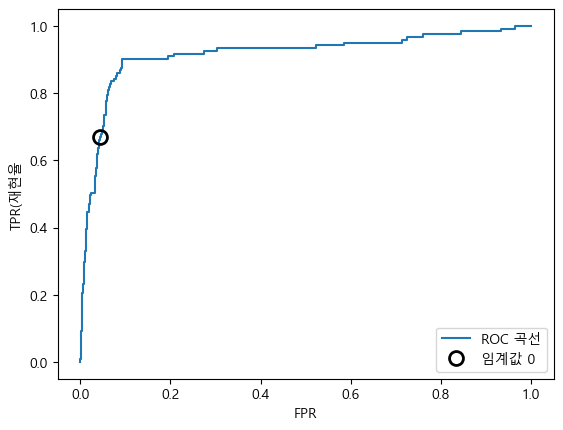

In [4]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
fpr, tpr, threshold = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC 곡선")
plt.xlabel("FPR")
plt.ylabel("TPR(재현율)")

# 0 근처의 임계값을 찾음
close_zero = np.argmin(np.abs(threshold))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="임계값 0", fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.show()



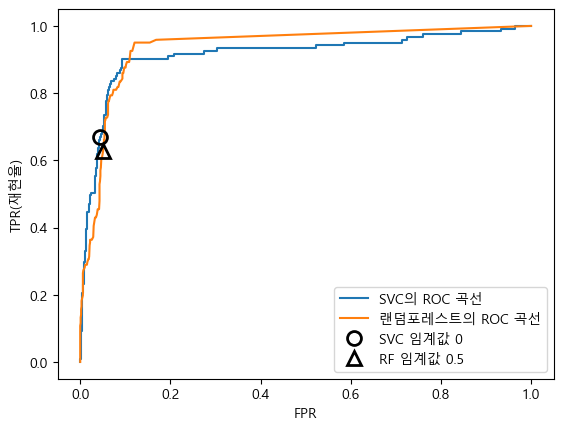

In [9]:
# RandomForest와 SVM의 ROC 곡선 비교
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label="SVC의 ROC 곡선")
plt.plot(fpr_rf, tpr_rf, label="랜덤포레스트의 ROC 곡선")

plt.xlabel("FPR")
plt.ylabel("TPR(재현율)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="SVC 임계값 0", fillstyle="none", c="k", mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10, label="RF 임계값 0.5", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)
plt.show()

### AUC (Area Under the Curve) 구하기

In [10]:
# AUC
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("랜덤포레스트의 AUC : {:.3f}".format(rf_auc))
print("SVC의 AUC : {:.3f}".format(svc_auc))

# 랜덤포레스트의 성능이 svm보다 조금 더 나음.
# 불균형한 데이터셋에서 정확도보다 AUC가 훨씬 좋은 지표

랜덤포레스트의 AUC : 0.937
SVC의 AUC : 0.916


### ROC curve 쉽게 바로 그리기 : RocCurveDisplay

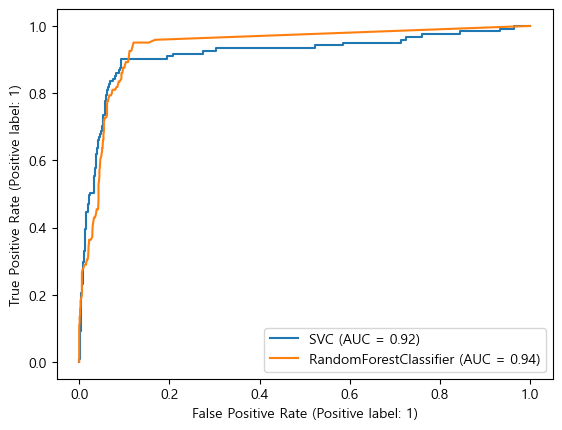

In [11]:
from sklearn.metrics import RocCurveDisplay
# from_estimator 사용하여 roc curve 그리기

fig, ax = plt.subplots()
# SVC 곡선 그리기
RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax)
# 랜덤 포레스트 곡선 그리기
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax)
plt.show()

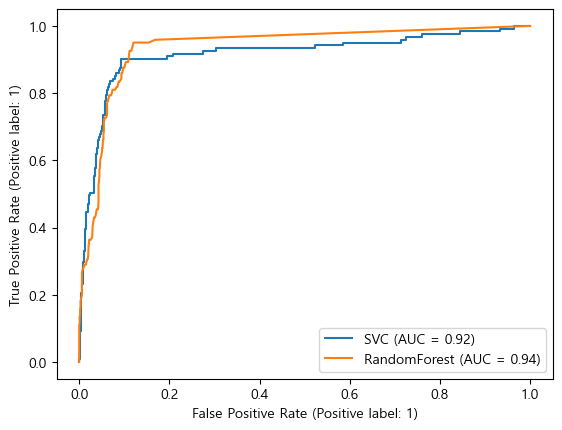

In [13]:
# from_predictions 사용하여 roc curve 그리기
fig, ax = plt.subplots()
# SVC 곡선 그리기
RocCurveDisplay.from_predictions(y_test, svc.decision_function(X_test), name="SVC", ax=ax)
RocCurveDisplay.from_predictions(y_test, rf.predict_proba(X_test)[:,1], name="RandomForest", ax=ax)
plt.show()

### digits 데이터셋에서 9와 다른 숫자 구분하기

gamma : 1.00 정확도 : 0.90 AUC : 0.50
gamma : 0.10 정확도 : 0.90 AUC : 0.96
gamma : 0.01 정확도 : 0.90 AUC : 1.00


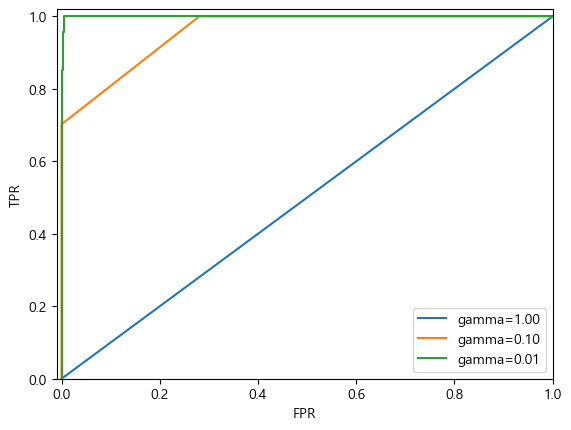

In [15]:
from sklearn.datasets import load_digits

digits = load_digits()
y = (digits.target == 9)

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print("gamma : {:.2f} 정확도 : {:.2f} AUC : {:.2f}".format(gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.2f}".format(gamma))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()


**결론**
- 세 가지 gamma 값에 대한 정확도는 0.90으로 모두 같음
- gamma=1.0에서 AUC는 무작위로 선택한 수준과 같음 (auc = 0.5)
- gamma=0.01에서는 AUC가 1을 얻어 아주 좋은 모델.
- 하지만 AUC의 값은 기본 임계값과는 상관없으므로, AUC가 높은 모델에서 좋은 분류 결과를 얻으려면 '결정 임계값'을 조정해야 함